In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import eigs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import os
from skimage.feature import match_template
from lightgbm import LGBMClassifier as lgb

%matplotlib inline

# Preparations

In [44]:
# helpers and utils

def make_image_vector(image_list, new_size):
    D = np.empty([len(image_list), new_size])
    i = 0
    for image in image_list:
        D[i, :] = image
        i += 1
    return D

def avgfaces_by_emotion(df):
    avgfaces = []
    
    for emotion in sorted(df['emotion'].unique()):
        sub_df = df[df['emotion']==emotion]
        
        avg_pixels = np.mean(sub_df['pixels'].values)

        avgfaces.append((avg_pixels, emotion))
        
    return avgfaces

def eigenfaces_by_emotion(df, k=1):
    eigenfaces = []
    
    for emotion in sorted(df['emotion'].unique()):
        sub_df = df[df['emotion']==emotion]
        
        pixels = list(sub_df['pixels'].values)
        D = make_image_vector(pixels, 48*48)
        A = np.dot(D.T, D)
        
        # Find k largest magnitude (LM) eigenvectors
        vals, vecs = eigs(A, k, which='LM')
        
        eigenfaces.extend([(vec.reshape(48, 48).astype(float), emotion) for vec in vecs.T])
        
    return eigenfaces

def clean(img, t1):
    
    img = img.reshape(48,48)
    corr_skimage = match_template(img, t1, pad_input=True)
    un = (corr_skimage > 0.53)
    if (np.unique(un[12:22,9:18]) != False).any() and (np.unique(un[12:22,30:39]) != False).any() and (img.sum() > 220000) and (img.sum() < 400000):
        return 1
    else: return 0
    
def plot_face_and_emotion(plot_nrow, plot_ncol, face_list):
    fig, axes = plt.subplots(plot_nrow, plot_ncol, figsize=(15, 15))
    for i, (face, emotion) in enumerate(face_list):
        ax = axes.ravel()[i]
        ax.imshow(face.reshape(48, 48), cmap='gray')
        # Turn off tick labels
        ax.set_xlabel(emo_dict[emotion])
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [37]:
emo_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'STOHAN', 5: 'Surprise', 6: 'Neutral'}

In [38]:
# reading the data
os.chdir(os.getcwd() + '/fer2013')
full_data = pd.read_csv('fer2013.csv')
os.chdir('../')
print('Current directory: {} \n'.format(os.getcwd()))
full_data.head()
df = full_data

Current directory: C:\Users\Maksim Komatovskiy\Desktop\cv_proj 



In [39]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype=np.float))

In [40]:
# CLEANING THE DATASET

# needed inputs and templates

img = df['pixels'].iloc[33].reshape(48,48)
t1 = img[15:25,8:20]

    
# applying the cleaning function

df['deсision'] = df['pixels'].apply(lambda x: clean(x, t1))


# keep only the appropriate ones

df=df.drop(df[df['deсision']==0].index)

# Model

In [41]:
avgfaces = avgfaces_by_emotion(df)

In [42]:
eigenfaces = eigenfaces_by_emotion(df, 1)

C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Maksim Komatovskiy\anaconda_\envs\venv\lib\site-packages\ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary par

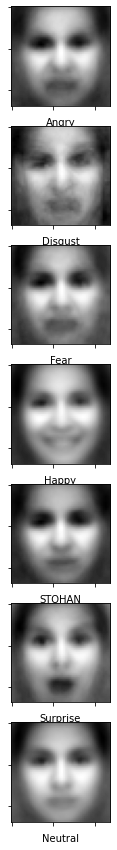

In [45]:
plot_face_and_emotion(7, 1, avgfaces)

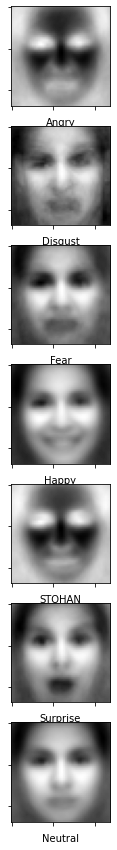

In [46]:
plot_face_and_emotion(7, 1, eigenfaces)

In [137]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(df['pixels'], df['emotion'], test_size=0.33, random_state=42,shuffle = True)

In [138]:
# solving dimensionality messings

X_train = make_image_vector(X_train, 48*48)
X_test = make_image_vector(X_test, 48*48)

In [139]:
# mapping the values for lables

y_train = y_train.map(emo_dict).values
y_test = y_test.map(emo_dict).values

In [140]:
# initializing the classifiers

clf = DecisionTreeClassifier()
clf2 = lgb()
rf = RandomForestClassifier()

In [ ]:
'''

Do not use

'''


clf2.fit(X_train,y_train)
y_pred = clf2.predict(X_test)

from sklearn.metrics import f1_score

f1_score(y_pred,y_test,average='micro')

# Using projections as an input to the model

In [143]:
def mean_column(A):
    return A.mean(axis = 1)


def subtract_column_mean(A):
    column_mean = mean_column(A)
    return A - column_mean.reshape(-1,1)

def approximate_with_rank(A,r,return_decomposition = False):

    u,s,vh = np.linalg.svd(A,full_matrices = False) # decomposition
    #print(u.shape, s.shape,vh.shape)
    s = s[:r] #truncation
    u = u[:,:r]
    vh = vh[:r,:]
    #print(u.shape, s.shape,vh.shape)
    
    if return_decomposition:
        return u,s,vh
    else:
        A_ = np.dot(u,np.dot(np.diag(s),vh))
        return A_

In [144]:
F = X_train.T
F.shape

F_test = X_test.T

In [145]:
F0 = subtract_column_mean(F)

In [156]:
# we select the approximation strength (rank of truncation), which, obviously, should be less then min(F0.shape[0],F0.shape[1])

R = 500


# we build an R-rank approximation of the centralized F-matrix

F0_approx = approximate_with_rank(F0, r = R)

In [157]:
# same, but keeping the factorization itself

U0,S0,Vh0 = approximate_with_rank(F0, 
                                      r = R,
                                      return_decomposition=True)

In [158]:
projection_matrix = U0.T

In [159]:
X_test_proj = projection_matrix@F_test

In [160]:
rowwise = X_test_proj.T

In [161]:
X_svd_for_fit = (np.diag(S0)@Vh0).T

In [162]:
# finally, we fit the model on the features of coeficient in the eigenbasis

clf2.fit(X_svd_for_fit,y_train)

LGBMClassifier()

In [163]:
y_eig_pred = clf2.predict(rowwise)

In [168]:
f1_score(y_eig_pred,y_test,average='weighted')

0.47086893265882135

In [165]:
import sklearn
sklearn.metrics.confusion_matrix(y_eig_pred,y_test)

array([[ 19,   0,   0,   2,   0,   4,   0],
       [  0,   2,   0,   0,   0,   0,   0],
       [  5,   1,  43,   8,  13,  12,   9],
       [ 81,  10,  65, 341,  77,  74,  25],
       [111,  16,  85, 133, 273, 155,  46],
       [  4,   0,   1,   2,   5,  17,   4],
       [ 45,   7,  62,  50,  52,  47, 160]], dtype=int64)